Intro:
This is a sequence classification task, where given an input sentence (tweet) in Greek , the classifier is supposed to output one out of the 3 sentiments (positive/negative/neutral). We 're therefore dealing with a multiclass classification task.
The context of our classifier is politics and specifcally the General elections in Greece.

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/stopwords-gr/clean_gr_stops.csv
/kaggle/input/sentiment-dicts/updated_negative_words.txt
/kaggle/input/sentiment-dicts/updated_positive_words.txt
/kaggle/input/ys19-2023-assignment-1/sample_submission.csv
/kaggle/input/ys19-2023-assignment-1/test_set.csv
/kaggle/input/ys19-2023-assignment-1/valid_set.csv
/kaggle/input/ys19-2023-assignment-1/train_set.csv


In [2]:
!pip install demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import numpy as np
import demoji
#for vectorisation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.preprocessing import StandardScaler

#for training 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression

#Feature selection
from sklearn.feature_selection import SelectKBest, mutual_info_classif

#For evaluation of model
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score, precision_score, recall_score, f1_score


#For Hyper-tuning model
from sklearn.model_selection import GridSearchCV
import pickle

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def read_explore_clean_dataset(dataset_path, text_column='Text', label_column='Sentiment'):
    # Load the dataset
    df = pd.read_csv(dataset_path, encoding='utf-8')
    print(df.info())
    # Count the number of samples in each class
    class_counts = df[label_column].value_counts()

    # Clean the dataset
    # Drop duplicate rows
    df = df.drop_duplicates(subset=[text_column, label_column])

    # Drop rows with NaN values
    df = df.dropna(subset=[text_column, label_column])

    # Reset index after dropping rows
    df = df.reset_index(drop=True)
    print('Dataframe checked for NaN values and duplicates!')

    return df

In [5]:
def sep_punc(x):
    punc = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~؛،؟؛.»«”'
    out = []
    for char in x:
        if char in punc:
            out.append(' ' + char + ' ')
        else:
            out.append(char)
    return ''.join(out)

def remove_emojis(text):
    return demoji.replace(text, '')

def read_lexicon(file_path):
    lexicon = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # Split the line into word and polarity using regex
            match = re.match(r'(\S+)\s+\(([-+]?\d+)\)', line.strip())
            if match:
                word, polarity = match.groups()
                lexicon[word] = int(polarity)
    return lexicon

def add_sentiment_counts(df, positive_lexicon, negative_lexicon):
    # Calculate the count of positive and negative words in each sentence
    positive_counts = []
    negative_counts = []

    for tweet in df['Text']:
        positive_count = sum(positive_lexicon.get(word, 0) for word in tweet.lower().split())
        negative_count = sum(negative_lexicon.get(word, 0) for word in tweet.lower().split())

        positive_counts.append(positive_count)
        negative_counts.append(negative_count)

    # Add the counts to the DataFrame
    df['positive_count'] = positive_counts
    df['negative_count'] = negative_counts

def preprocess_text_first_step(text):
    # Remove retweets
    text = re.sub(r'^RT[\s]+', '', text, flags=re.IGNORECASE)
    # Remove usernames @
    text = re.sub(r'@[^\s]+', '', text)
    # Remove URLs 
    text = re.sub(r'https\S+', '', text)
    url_words = ['url', 'URL', 'html', 'HTML', 'http', 'HTTP']
    for u in url_words:
        text = re.sub(u, '', text)
    return text, len(text)

def preprocess_text_second_step(text):
  # Separate punctuation characters
    text = sep_punc(text)
    # Remove punctuation characters
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)
    # Remove Latin characters
    text = re.sub(r'[a-zA-Z]+', '', text)
    # Remove numbers
    text = re.sub(r'\b\d+\b', '', text)
    return text

def preprocess_text_third_step(text,stopwords_file):
  # Remove words with character length equal to or less than 3
    words = text.split()
    filtered_words = [word for word in words if len(word) > 1]
    text = ' '.join(filtered_words)
    text = str(text).lower().strip()
    # Remove stopwords
    stop_words_df = pd.read_csv(stopwords_file)
    # Exclude specific stop words
    excluded_stopwords = ['όχι', 'μην', 'δεν', 'πολύ', 'πολυ']
    stop_words_set = set(stop_words_df['0'].tolist()) - set(excluded_stopwords)
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words_set]
    text = ' '.join(filtered_words)
    text = remove_emojis(text)
   # remove the extra whitespace
    text = re.sub(' +', ' ', text)

    return text


def preprocess_dataframe(df, positive_lexicon_file, negative_lexicon_file, stopwords_file):
    # Apply the first step of preprocessing and capture the character length
    df['Text'], df['n_chars'] = zip(*df['Text'].map(preprocess_text_first_step))

    # Apply the second step of preprocessing
    df['Text'] = df['Text'].apply(preprocess_text_second_step)

    # Map sentiment column to discrete values
    #polarity_mapping = {'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1}
    #df['Sentiment'] = df['Sentiment'].map(polarity_mapping)

    # Read lexicons from files
    positive_lexicon = read_lexicon(positive_lexicon_file)
    negative_lexicon = read_lexicon(negative_lexicon_file)

    # Add sentiment counts
    add_sentiment_counts(df, positive_lexicon, negative_lexicon)

    # Apply the third step of preprocessing
    df['Text'] = df['Text'].apply(lambda x: preprocess_text_third_step(x, stopwords_file))

    return df

In [6]:
#def print_sentences_with_high_symbol_percentage(df, text_column='Text', threshold=0.5, num_sentences=5):
    # Assuming 'Text' is the column containing the sentences
#    sentences = df[text_column]

    # Function to check if more than the specified percentage of words start with '@' or '#'
 #   def should_print(sentence):
 #       words = sentence.split()
 #       symbol_count = sum(1 for word in words if word.startswith('@') or word.startswith('#'))
 #       return symbol_count / len(words) > threshold

    # Print some of the sentences that meet the condition
 #   print(f"Some sentences with more than {threshold * 100}% symbols:")
 #   for sentence in sentences[sentences.apply(should_print)].head(num_sentences):
 #       print(sentence)

#WordCloud of Latin characters

In [7]:
#latin_hashtags_text = ' '.join(latin_hashtags_list)

#wordcloud = WordCloud(width=800, height=400, background_color='white').generate(latin_hashtags_text)

#plt.figure(figsize=(10, 5))
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis('off')
#plt.title("Word Cloud of Tweets in Latin Characters in All Train Set")
#plt.show()

#Mean punct count per class
Is the amount of puntuation used in a tweet a decissive factor for the sentiment classification?

In [8]:
#def count_punctuation(tweet):
#    return sum(1 for char in tweet if char in string.punctuation)

#cleaned_df['PunctuationCount'] = cleaned_df['Text'].apply(count_punctuation)

# Group by 'Sentiment' and calculate the mean count of punctuation characters
#mean_punctuation_count_per_sentiment = cleaned_df.groupby('Sentiment')['PunctuationCount'].mean()

#print(mean_punctuation_count_per_sentiment)
# Plotting
#plt.bar(mean_punctuation_count_per_sentiment.index, mean_punctuation_count_per_sentiment.values)
#plt.xlabel('Sentiment Class')
#plt.ylabel('Mean Punctuation Count')
#plt.title('Mean Punctuation Count per Sentiment Class')
#plt.show()

#Mean character length per tweet
Test if the length of a tweet in characters is a decissive factor for the sentiment class

In [9]:
#cleaned_df['CharLength'] = cleaned_df['Text'].apply(len)

# Calculate the mean character length per sentiment class
#mean_char_length_per_sentiment = cleaned_df.groupby('Sentiment')['CharLength'].mean()

#print(mean_char_length_per_sentiment)

In [10]:
#from scipy.stats import f_oneway

# Plotting
#plt.bar(mean_char_length_per_sentiment.index, mean_char_length_per_sentiment.values)
#plt.xlabel('Sentiment Class')
#plt.ylabel('Mean Character Length per Tweet')
#plt.title('Mean Character Length per Tweet for Each Sentiment Class')
#plt.show()

# Statistical analysis
#class_0 = cleaned_df[cleaned_df['Sentiment'] == 'POSITIVE']['CharLength']
#class_1 = cleaned_df[cleaned_df['Sentiment'] == 'NEGATIVE']['CharLength']
#class_2 = cleaned_df[cleaned_df['Sentiment'] == 'NEUTRAL']['CharLength']

# Perform one-way ANOVA test
#f_statistic, p_value = f_oneway(class_0, class_1, class_2)

#print(f"One-way ANOVA p-value: {p_value}")

#Post hoc test if the overall test is significant (p-value < 0.05)

#from statsmodels.stats.multicomp import pairwise_tukeyhsd

#tukey_result = pairwise_tukeyhsd(cleaned_df['CharLength'], cleaned_df['Sentiment'])
#print(tukey_result)

**Finally a clue!**
Mean character lenghth can be a **helpful** factor for classifiying Neutral/positive nad negative classes

#Adjectve counts

In [11]:
#def add_adjective_count(df):
    # Load the spaCy language model
#    nlp = spacy.load('el_core_news_lg')

    # Apply POS tagging and count adjectives for each tweet
#    df['POS_tags'] = df['Text'].apply(lambda text: [token.pos_ for token in nlp(text)])
#    df['Adjectives_count'] = df['POS_tags'].apply(lambda pos_tags: pos_tags.count('ADJ'))

In [12]:
# Plot mean count of adjectives per sentiment class
#plt.figure(figsize=(10, 6))
#sns.barplot(x='Sentiment', y='Adjectives_count', data=df_no_outliers, ci='sd')
#plt.xlabel('Sentiment Class')
#plt.ylabel('Mean Count of Adjectives')
#plt.title('Mean Count of Adjectives with Standard Deviation per Sentiment Class')
#plt.show()

Sentiment Lexicons

In [13]:
#Let's visualize the positive words of the positive tweets in a WordCloud


# Filter positive words in positive tweets based on the lexicon
#positive_words = ' '.join([word for tweet, polarity in zip(df_no_outliers['Text'],df_no_outliers['Sentiment'])
#                           if polarity == 1
#                           for word in tweet.lower().split() if word in positive_lexicon])

# Generate word cloud for positive words
#positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_text(positive_words)

# Plot the word cloud
#plt.figure(figsize=(8, 4))
#plt.imshow(positive_wordcloud, interpolation='bilinear')
#plt.title('Positive Words in Positive Tweets Word Cloud')
#plt.axis('off')
#plt.show()

In [14]:
#Let's visualize the negative words of the negative tweets in a WordCloud
# Filter negative words in positive tweets based on the lexicon
#negative_words = ' '.join([word for tweet, polarity in zip(df_no_outliers['Text'], df_no_outliers['Sentiment'])
#                           if polarity == -1
#                           for word in tweet.lower().split() if word in negative_lexicon])

# Generate word cloud for positive words
#negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_text(negative_words)

# Plot the word cloud
#plt.figure(figsize=(8, 4))
#plt.imshow(negative_wordcloud, interpolation='bilinear')
#plt.title('Negative Words in Negative Tweets Word Cloud')
#plt.axis('off')
#plt.show()

So based on the above Analysis the features we are going to train our model on are:
1. the vectorised and preprocessed text (tfidf/countvectorizer)
2. count of positive words
3. the count of negative words
4. the count of characters per tweet.

Implementations

In [15]:
dataset_path='/kaggle/input/ys19-2023-assignment-1/train_set.csv'
dev_path='/kaggle/input/ys19-2023-assignment-1/valid_set.csv'
positive_lexicon_file= '/kaggle/input/sentiment-dicts/updated_positive_words.txt'
negative_lexicon_file='/kaggle/input/sentiment-dicts/updated_negative_words.txt'
stopwords_file = '/kaggle/input/stopwords-gr/clean_gr_stops.csv'


In [16]:
df = read_explore_clean_dataset(dataset_path)
df = preprocess_dataframe(df, positive_lexicon_file, negative_lexicon_file, stopwords_file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36630 entries, 0 to 36629
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   New_ID     36630 non-null  int64 
 1   Text       36630 non-null  object
 2   Sentiment  36630 non-null  object
 3   Party      36630 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.1+ MB
None
Dataframe checked for NaN values and duplicates!


In [17]:
def get_columns_vectorize_stack_split(data, text_column, numeric_columns, target_column, selected_numeric_columns=None,
                                      test_size=0.2, random_state=42, vectorizer=TfidfVectorizer,
                                      ngram_range=(1, 1),max_features=1000):   
    """
    Preprocesses data, vectorizes text data, scales numeric data, and splits it into training and testing sets.

    Parameters:
    - data: pandas DataFrame, input data
    - text_column: str, the name of the text column in the DataFrame
    - numeric_columns: list, names of all numeric columns in the DataFrame
    - target_column: str, name of the target column in the DataFrame
    - selected_numeric_columns: list or None, names of numeric columns to include in training (default is None, which includes all numeric columns)
    - test_size: float, the proportion of the dataset to include in the test split (default is 0.2)
    - random_state: int, random seed for reproducibility (default is 42)
    - vectorizer: sklearn.feature_extraction.text vectorizer class (default is TfidfVectorizer)
    - ngram_range: tuple, (min_n, max_n), the range of n-values for different n-grams (default is (1, 1))
    - max_features: int or None, if not None, build a vocabulary that only considers the top max_features ordered by term frequency

    Returns:
    - X_train, X_test, Y_train, Y_test
    """
    # Separate text and selected numeric data
    text_data = data[text_column]
    numeric_data = data[selected_numeric_columns] if selected_numeric_columns else data[numeric_columns]

    # Vectorize text data
    vectorizer = vectorizer(ngram_range=ngram_range, max_features=max_features)
    X_text = vectorizer.fit_transform(text_data)
    #print('Number of features:', len(vectorizer.vocabulary_))

    if numeric_columns:
        scaler = StandardScaler()
        numeric_data_scaled = scaler.fit_transform(numeric_data)
        X_combined = np.hstack((X_text.toarray(), numeric_data_scaled))
    else:
        X_combined = X_text.toarray()

    # Target variable
    y = data[target_column]

    # Split the data
    X_train, X_test, Y_train, Y_test = train_test_split(X_combined, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, Y_train, Y_test


  

        

In [18]:
selected_numeric_columns = ['n_chars', 'positive_count', 'negative_count']
X_train, X_test, Y_train, Y_test = get_columns_vectorize_stack_split(df, 'Text', ['n_chars', 'positive_count', 'negative_count'], 'Sentiment', selected_numeric_columns)

Hpyperparameter tuning/optimisation with GridSearchCV  technique (brute force approach)

In [19]:
def find_best_parameters(X_train, Y_train):
    """
    Performs a grid search to find the best hyperparameters for a logistic regression model.
    Parameters:
    - X_train: array-like or pd.DataFrame, training input samples
    - Y_train: array-like or pd.Series, training labels

    Returns:
    - best_params: dict, the best hyperparameters found by the grid search
    """
    # Define the hyperparameters to search
    param_grid = {
        'penalty': ['l1'],
        'C': [0.001, 0.01, 0.1, 1.0],
        'solver': ['saga']
    }
    model = LogisticRegression(max_iter=1000)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1_micro', cv=5)
    grid_search.fit(X_train, Y_train)
    best_params = grid_search.best_params_
    print('Best parameters:',best_params)
    print('Micro F1:',grid_search.best_score_)

    return best_params

In [20]:
best_hyperparameters=find_best_parameters(X_train, Y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'saga'}
Micro F1: 0.381245072856791


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Metrics (accuracy, F1 micro,precision micro, recall micro)

In [21]:
def print_metrics(Y_true, Y_pred):
    # Calculate metrics
    accuracy = accuracy_score(Y_true, Y_pred) * 100
    precision = precision_score(Y_true, Y_pred, average='micro') * 100
    recall = recall_score(Y_true, Y_pred, average='micro') * 100
    f_measure = f1_score(Y_true, Y_pred, average='micro') * 100

    print('\nMetrics:')
    print('Accuracy: {} %'.format(accuracy))
    print('Precision: {} %'.format(precision))
    print('Recall: {} %'.format(recall))
    print('F1 Score: {} %'.format(f_measure))

In [22]:
def train_evaluate_and_save(X_train, Y_train, X_test, Y_test, model_save_path,feature_selection=None, k_best=None):
    """
    Trains a logistic regression model based on the best parameters found through GridSearchCV, prints out metrics on
    the splitted test set of the tran set, saves the trained model.
    Optionally you can perform feature selection with mutual info classifcation calling: feature_selection='mutual_info_classif', k_best=10 --whatever
    ok Kbest features you want to test
    This is meant for the train set

    Parameters:
    - X_train: array-like or pd.DataFrame, training input samples
    - Y_train: array-like or pd.Series, training labels
    - X_test: array-like or pd.DataFrame, test input samples
    - Y_test: array-like or pd.Series, test labels
    - model_save_path: str, path to save the trained model
    
    """
    if feature_selection == 'mutual_info_classif':
        if k_best is None:
            raise ValueError("If feature_selection is specified, k_best must be provided.")
        
        # Select top k_best features using mutual info classification
        selector = SelectKBest(score_func=mutual_info_classif, k=k_best)
        X_train = selector.fit_transform(X_train, Y_train)
        X_test = selector.transform(X_test)
    
    # Create a logistic regression model
    model = LogisticRegression(penalty='l1', C=1.0, solver='saga', n_jobs=-1, random_state=42, max_iter=1000)
    
    # Train the model on the entire training set
    model.fit(X_train, Y_train)

    # Predict on the test set
    Y_pred = model.predict(X_test)

    # Print metrics
    print_metrics(Y_test, Y_pred)
    
    # Save the trained model to disk
    with open(model_save_path, 'wb') as model_file:
        pickle.dump(model, model_file)
    print('model saved!')


model_save_path = 'log_reg_tfidf_uni_model.pkl'
train_evaluate_and_save(X_train, Y_train, X_test, Y_test, model_save_path)




/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Metrics:
Accuracy: 37.687687687687685 %
Precision: 37.687687687687685 %
Recall: 37.687687687687685 %
F1 Score: 37.687687687687685 %
model saved!


Function for the **evaluation on the dev set** with all evaluation metrics, learning curve, confusion matx, classification report

In [23]:
def load_and_predict(saved_model, X_train, Y_train, X_test, Y_test, scoring='f1_micro'):
    """
    Load a pre-trained model, predict on the test set, and evaluate the model.

    Parameters:
    - saved_model: str, path to the saved model file (pickle)
    - X_train: array-like, training input samples
    - Y_train: array-like, training labels
    - X_test: array-like, test input samples
    - Y_test: array-like, test labels

    Returns:
    - None
    """
    # Load the pre-trained model
    loaded_model = pickle.load(open(saved_model, 'rb'))

    # Train the model using the training set
    loaded_model.fit(X_train, Y_train)
    print('\nFitting data to the loaded logistic regression model...')

    # Make model predictions
    y_test_predict = loaded_model.predict(X_test)

     # Calculate accuracy of Logistic regression model 
    LR_accuracy = metrics.accuracy_score(Y_test,y_test_predict)*100

  # Precision score
    precision = metrics.precision_score(Y_test,y_test_predict,average='micro')*100
  
  # Recall Score
    recall = metrics.recall_score(Y_test,y_test_predict,average='micro')*100
   
  # F measure score
    f_measure = metrics.f1_score(Y_test,y_test_predict,average='micro')*100
  
    print('\nMetrics:')
    print('Accuracy: {} %'.format(LR_accuracy))
  
    precision, recall, fscore, support = score(Y_test,y_test_predict)

    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))
    print('support: {}'.format(support))
  
  # Get the classificatin report from the confusion matrix
    print('\nClassification report:\n',classification_report(Y_test,y_test_predict,labels = np.unique(y_test_predict)))

  # Use the learning curve to get training and test scores along with train sizes
    train_sizes, train_scores, validation_scores = learning_curve(loaded_model, X_train, Y_train, cv=5, n_jobs=1,scoring=scoring, train_sizes=np.linspace(0.01, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)

    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Score')
    plt.plot(train_sizes, validation_scores_mean, label='Validation Score')
    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel(scoring.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()
    
    cm = confusion_matrix(Y_test,y_test_predict)
  # Visualize the confusion matrix
    conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0', 'Predicted:1','Predicted:-1'], index =['True:0', 'True:1','True:-1'])
    plt.figure(figsize = (8, 5))
    sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Spectral")
  
    return plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5232 entries, 0 to 5231
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   New_ID     5232 non-null   int64 
 1   Text       5232 non-null   object
 2   Sentiment  5232 non-null   object
 3   Party      5232 non-null   object
dtypes: int64(1), object(3)
memory usage: 163.6+ KB
None
Dataframe checked for NaN values and duplicates!

Fitting data to the loaded logistic regression model...

Metrics:
Accuracy: 39.6370582617001 %
precision: [0.38629283 0.38478747 0.4265233 ]
recall: [0.34444444 0.50292398 0.34492754]
fscore: [0.36417034 0.43599493 0.38141026]
support: [360 342 345]

Classification report:
               precision    recall  f1-score   support

    NEGATIVE       0.39      0.34      0.36       360
     NEUTRAL       0.38      0.50      0.44       342
    POSITIVE       0.43      0.34      0.38       345

    accuracy                           0.40      1047
   mac

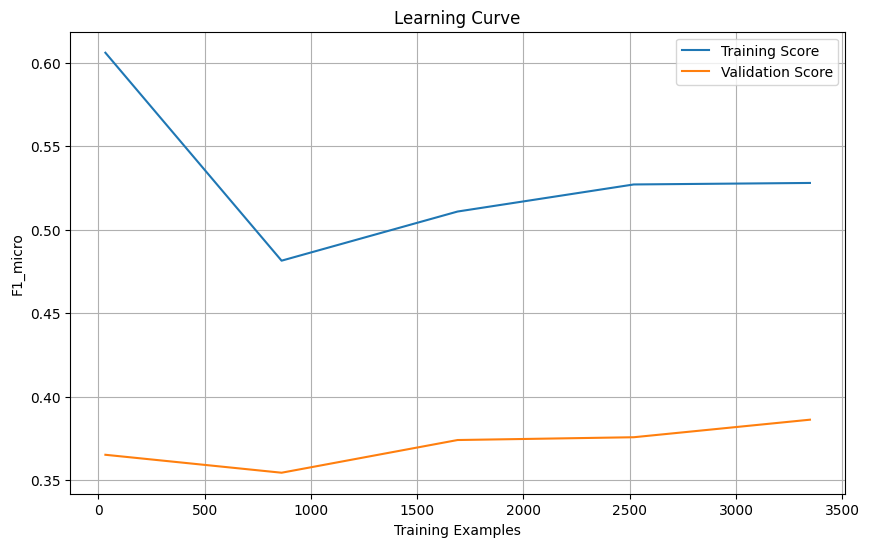

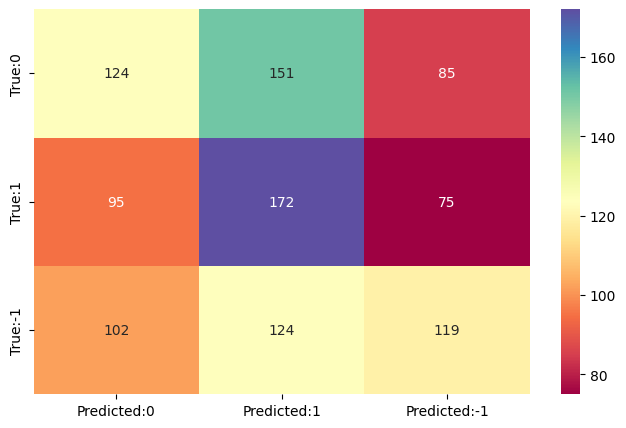

In [24]:
saved_model_path = '/kaggle/working/log_reg_tfidf_uni_model.pkl'
df_dev = read_explore_clean_dataset(dev_path)
df_dev = preprocess_dataframe(df_dev, positive_lexicon_file, negative_lexicon_file, stopwords_file)
selected_numeric_columns = ['n_chars', 'positive_count', 'negative_count']
X_train_dev, X_test_dev, Y_train_dev, Y_test_dev = get_columns_vectorize_stack_split(df_dev, 'Text', ['n_chars', 'positive_count', 'negative_count'], 'Sentiment', selected_numeric_columns)
evaluation = load_and_predict(saved_model_path, X_train_dev, Y_train_dev, X_test_dev, Y_test_dev,scoring='f1_micro')

**For submission**: the following functions are meant for the test set, where the Y_test column is missing. Based on the saved model we will generate the predictions of the Y_test and for that we need to first bring the X_test data (the predictors) in a form that our model will understand (X_combined: includes the text feature vectors and the 3 scaled numeric columns stacked together)

In [25]:
def get_columns_vectorize_stack(data, text_column, numeric_columns, selected_numeric_columns=None,
                                random_state=42, vectorizer=TfidfVectorizer,
                                      ngram_range=(1, 1),max_features=1000):   
    """
    Preprocesses data, vectorizes text data, scales numeric data, and splits it into training and testing sets.

    Parameters:
    - data: pandas DataFrame, input data
    - text_column: str, the name of the text column in the DataFrame
    - numeric_columns: list, names of all numeric columns in the DataFrame
    - target_column: str, name of the target column in the DataFrame
    - selected_numeric_columns: list or None, names of numeric columns to include in training (default is None, which includes all numeric columns)
    - random_state: int, random seed for reproducibility (default is 42)
    - vectorizer: sklearn.feature_extraction.text vectorizer class (default is TfidfVectorizer)
    - ngram_range: tuple, (min_n, max_n), the range of n-values for different n-grams (default is (1, 1))
    - max_features: int or None, if not None, build a vocabulary that only considers the top max_features ordered by term frequency

    Returns:
    - X_combined
    """
    # Separate text and selected numeric data
    text_data = data[text_column]
    numeric_data = data[selected_numeric_columns] if selected_numeric_columns else data[numeric_columns]
    
    # Vectorize text data
    vectorizer = vectorizer(ngram_range=ngram_range, max_features=max_features)
    X_text = vectorizer.fit_transform(text_data)
    #print('Number of features:', len(vectorizer.vocabulary_))

    if numeric_columns:
        scaler = StandardScaler()
        numeric_data_scaled = scaler.fit_transform(numeric_data)
        X_combined = np.hstack((X_text.toarray(), numeric_data_scaled))
    else:
        X_combined = X_text.toarray()

    return X_combined

In [26]:
def load_and_predict_test(saved_model,X_test):
    
    # Load the trained model
    loaded_model = pickle.load(open(saved_model, 'rb'))

    # Make model predictions
    y_test_predict = loaded_model.predict(X_test)
    print(y_test_predict)
    return y_test_predict

In [27]:
saved_model_path = '/kaggle/working/log_reg_tfidf_uni_model.pkl'
test=pd.read_csv('/kaggle/input/ys19-2023-assignment-1/test_set.csv')
test= preprocess_dataframe(test, positive_lexicon_file, negative_lexicon_file, stopwords_file)
test_X=get_columns_vectorize_stack(test, 'Text', ['n_chars', 'positive_count', 'negative_count'], selected_numeric_columns)
predicted_polarities=load_and_predict_test(saved_model_path, test_X)

['POSITIVE' 'POSITIVE' 'NEUTRAL' ... 'NEUTRAL' 'NEGATIVE' 'NEGATIVE']


In [28]:
print(type(predicted_polarities))

<class 'numpy.ndarray'>


In [29]:
my_submission = pd.DataFrame({'Id': test.New_ID, 'Predicted': predicted_polarities})
my_submission.to_csv('submission-lt12200010.csv', index=False)